# Overfitting and Regularization

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [4]:
set_config(display='diagram')

## Settings

In [5]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [6]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

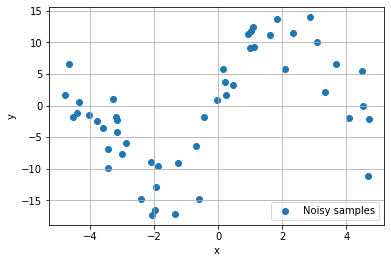

In [7]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

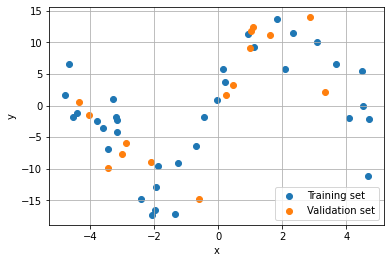

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

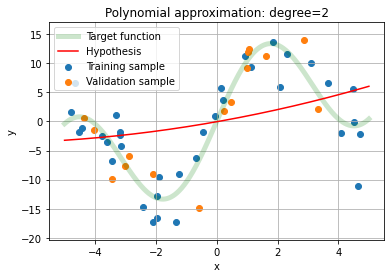

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

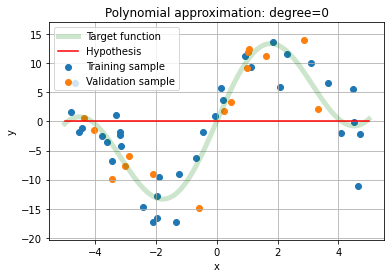

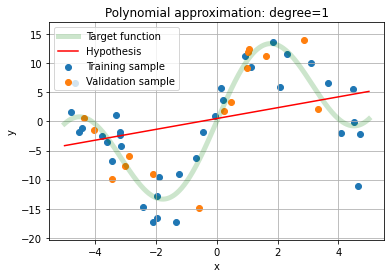

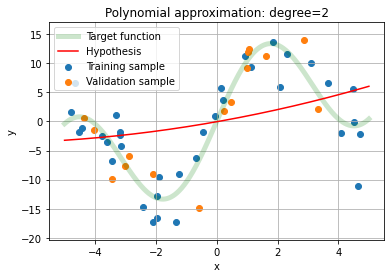

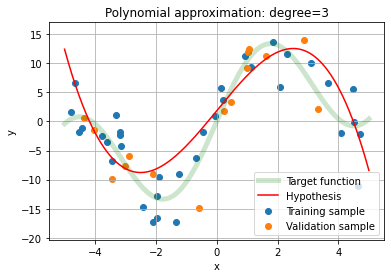

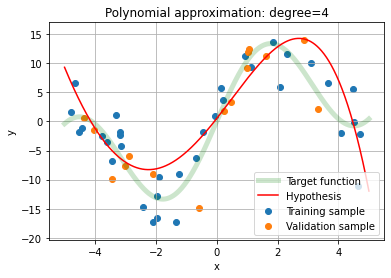

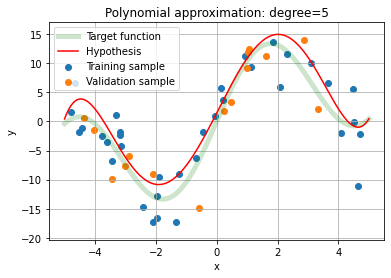

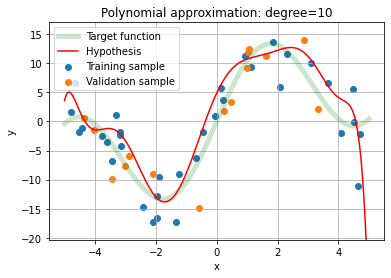

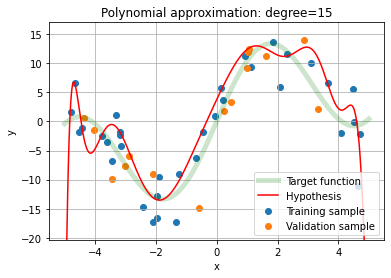

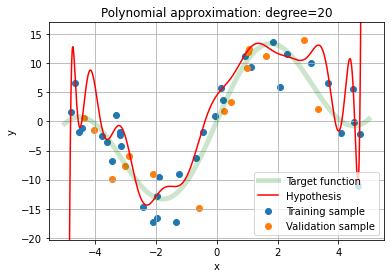

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

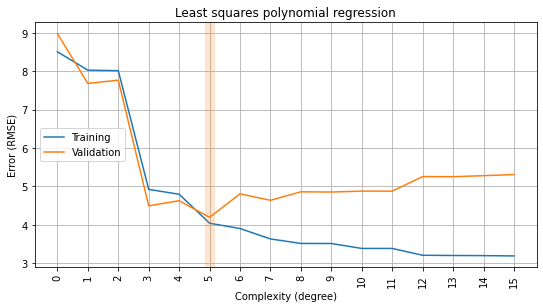

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

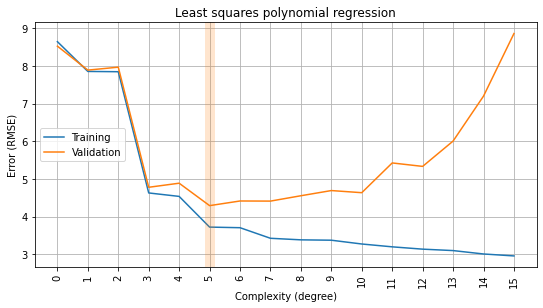

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

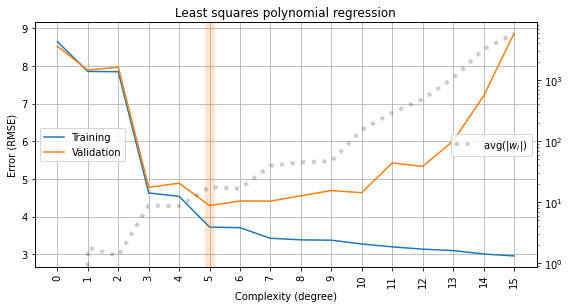

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

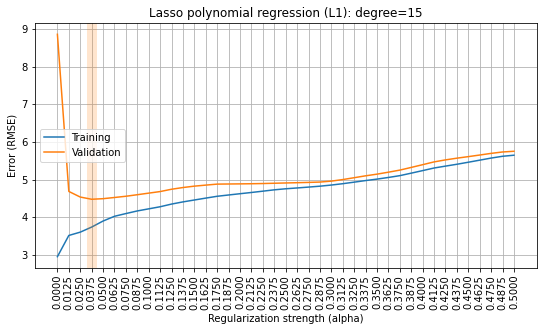

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

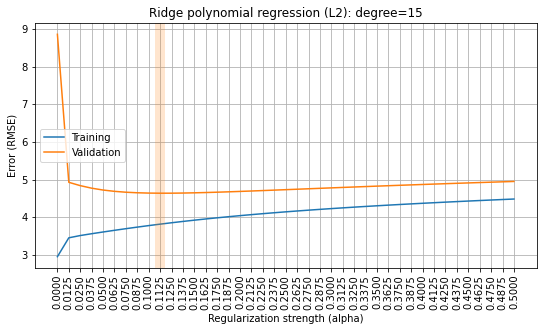

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

<hr>
A plot below demonstrates how weights average changes based on Alpha.<br>
In addition, there are graphs of training and validation sets' errors.

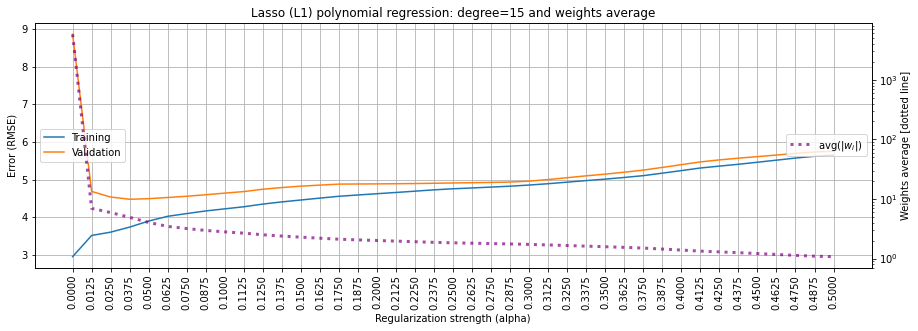

In [20]:
# the same thing as plot_fitting_graph - adds an extra Y label for weights
def better_plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(15, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt_2 = plt.twinx()
        plt.yscale(custom_scale)
        plt_2.plot(x, custom_metric, alpha=0.7, lw=3, ls='dotted', color='purple', label=custom_label) 
        plt_2.legend(loc='center right')  
        plt.ylabel('Weights average [dotted line]')
    plt.show()

rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score'])) 
    avg_coef.append(np.mean([
            np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
better_plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso (L1) polynomial regression: degree=15 and weights average')

#### L2

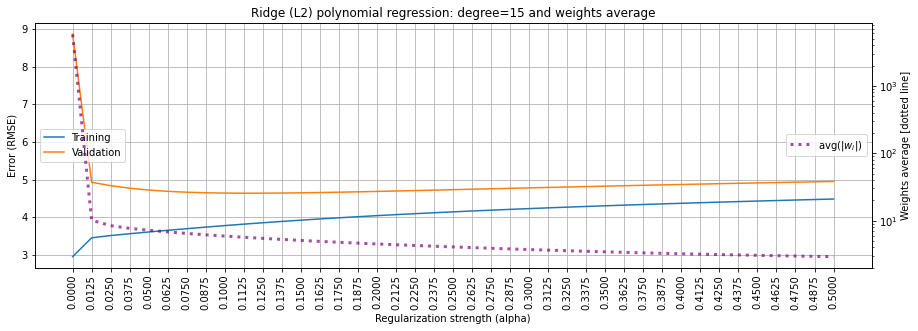

In [21]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score'])) 
    avg_coef.append(np.mean([
            np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
better_plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge (L2) polynomial regression: degree=15 and weights average')

#### Summary

<hr>
According to graphs above, the  average value of weights is indeed decreases when the value of alpha is increased. <br>
Thus, it serves as proof that weights are constrained - please refer to a graph below comparing weights when using L1 and L2 regularization methods (weights average with alpha = 0 is not displayed).<br>
It demonstrates that weights' average decrease for both Ridge and Lasso methods.

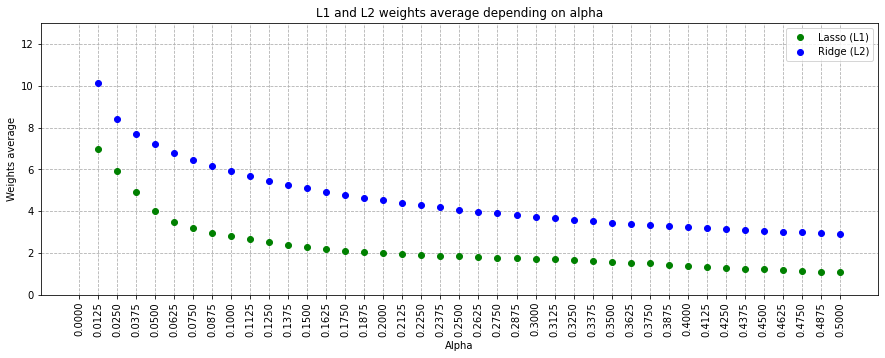

In [22]:
def get_weights_average (penalty, alpha): # run cross_validate and return mean of weights
    results = cross_validate(make_model(degree=15, penalty=penalty, alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    return (np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))

l1_avg_coef, l2_avg_coef = [], [] # create lists to store average weights 
for alpha in ALPHAS: 
    l1_avg_coef.append(get_weights_average('L1', alpha))
    l2_avg_coef.append(get_weights_average('L2', alpha))

# draw the plot
with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.ylim([0, 13]) # set limits to Y axis
    plt.plot(ALPHAS, l1_avg_coef, color='green', linestyle="", marker="o", label='Lasso (L1)')
    plt.plot(ALPHAS, l2_avg_coef, color='blue', linestyle="", marker="o", label='Ridge (L2)')
    plt.xlabel('Alpha')
    plt.ylabel('Weights average')
    plt.xticks(ALPHAS, rotation='vertical')
    plt.legend()     
    plt.title('L1 and L2 weights average depending on alpha') 
    plt.show()

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

<hr>
To demonstrate the number of "0" weights, there is a dataframe below that contains all weights and the number of zeroed weights (excluding w0 as it's awlays 0). 

In [27]:
def get_weights (penalty, alpha): # run cross_validate and return mean of weights
    results = cross_validate(make_model(degree=15, penalty=penalty, alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    weights = [] 
    for model in results['estimator']:
        model_coefficients = model['reg'].coef_
        weights.append(model_coefficients) # add weights calculated for each cross validation split
    weights = np.array(weights) # convert to np array
    #weights = weights[:,1:] # getting rid of the w0
    weights = np.mean(weights, axis=0) # calculate mean values of each of 16 weights
    return list(weights)

def calculate_zero_weigths (row): 
    weights = row.iloc[3:] # get values from all but 'Zeroed weights' and 'Alpha' columns
    zeroed_weights = len(np.where(weights == 0)[0]) # get indices of columns containing 0, its array and calculate its length
    row['Zeroed weights w/o w0'] = zeroed_weights # assign the calculated value to the 'Zeroed weights' column
    return row

l1_weights = [] # initialize the array to store weights
for alpha in ALPHAS: 
    l1_weights.append(get_weights('L1', alpha))
pd_l1_weights = pd.DataFrame(l1_weights) # create new dataframe
pd_l1_weights.columns=["w"+str(i) for i in range(0, 16)] #rename columns so that they represent weights
pd_l1_weights.insert(0, 'Alpha', ALPHAS) # add new column to the left 
pd_l1_weights.insert(1, 'Zeroed weights w/o w0', np.zeros(len(l1_weights), dtype=int)) # add new column and fill it with zeros
pd_l1_weights = pd_l1_weights.apply(calculate_zero_weigths, axis=1) # fill the column with actual values
pd_l1_weights #display the output

,Alpha,Zeroed weights w/o w0,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
0,0.0000,0.0,0.0,40.993316,8.294028,-199.327724,-331.102612,738.180635,2597.485587,-1262.498212,-8289.899532,-376.294618,12779.205700,3937.746944,-9495.984009,-4459.256884,2733.132403,1585.480096
1,0.0125,6.0,0.0,28.840109,0.428966,-43.538549,0.628747,0.000000,-0.409635,25.106773,0.000000,1.990993,0.000000,0.000000,0.000000,0.000000,-1.016782,-9.105437
2,0.0250,6.0,0.0,27.078698,0.584729,-38.581447,0.285368,0.000000,-0.388065,20.162863,0.000000,0.561569,0.000000,0.000000,0.000000,0.000000,-0.800371,-5.957517
3,0.0375,5.0,0.0,25.324386,0.700914,-33.616367,0.001363,0.000000,-0.262504,14.699659,-0.081327,0.000000,0.000000,0.000000,-0.001178,0.000000,-0.634701,-3.185489
4,0.0500,4.0,0.0,23.635303,0.637224,-28.774559,0.000000,0.000000,-0.037697,8.291724,-0.246238,1.116673,-0.024375,0.000000,-0.311496,0.000000,-0.274155,-1.096614
5,0.0625,6.0,0.0,22.359730,0.601035,-25.284687,0.000000,0.000000,0.000000,3.514833,-0.263770,2.615593,-0.297147,0.000000,0.000000,0.000000,-0.285026,-0.100311
6,0.0750,6.0,0.0,21.498759,0.561485,-23.267756,0.000000,0.000000,0.000000,1.225810,-0.249524,3.561968,-0.139114,0.000000,-0.142740,0.000000,-0.276116,0.000000
7,0.0875,5.0,0.0,20.727671,0.525817,-21.567697,0.000000,0.000000,-0.003082,0.000000,-0.238934,3.080435,-0.015614,0.697646,-0.247709,0.000000,-0.267861,0.000000
8,0.1000,5.0,0.0,20.107391,0.487097,-20.398442,0.000000,0.000000,-0.006410,0.000000,-0.078975,2.036737,-0.137273,1.113931,-0.262190,0.000000,-0.253393,0.000000
9,0.1125,5.0,0.0,19.526687,0.450518,-19.352018,0.000000,0.000000,-0.004733,0.000000,-0.003671,1.457019,-0.203373,1.148534,-0.097251,0.000000,-0.401237,0.000000


#### L2

In [29]:
# repeat actions above  for L2
l2_weights = []
for alpha in ALPHAS: 
    l2_weights.append(get_weights('L2', alpha))
pd_l2_weights = pd.DataFrame(l2_weights)
pd_l2_weights.columns=["w"+str(i) for i in range(0, 16)]
pd_l2_weights.insert(0, 'Alpha', ALPHAS)
pd_l2_weights.insert(1, 'Zeroed weights w/o w0', np.zeros(len(l1_weights), dtype=int))
pd_l2_weights = pd_l2_weights.apply(calculate_zero_weigths, axis=1)
pd_l2_weights

,Alpha,Zeroed weights w/o w0,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
0,0.0000,0.0,0.0,40.993316,8.294028,-199.327724,-331.102612,738.180635,2597.485587,-1262.498212,-8289.899532,-376.294618,12779.205700,3937.746944,-9495.984009,-4459.256884,2733.132403,1585.480096
1,0.0125,0.0,0.0,29.418257,-1.282098,-46.467914,7.512246,5.994204,-7.575867,16.230450,-2.945252,10.053670,4.605818,1.355950,4.625363,-5.100474,-5.378021,-8.215585
2,0.0250,0.0,0.0,27.906882,-0.876043,-40.304757,5.230989,0.473271,-3.897708,13.402855,-2.332695,11.203862,1.570682,4.072389,2.117969,-3.533826,-2.236292,-9.982394
3,0.0375,0.0,0.0,26.863814,-0.704703,-36.681081,4.486555,-1.796118,-2.671295,11.588223,-2.223052,11.027205,0.433777,4.893625,1.257181,-2.692197,-0.981507,-9.987017
4,0.0500,0.0,0.0,26.029291,-0.577266,-34.027778,4.076637,-3.041783,-2.081608,10.215454,-2.185275,10.539561,-0.145655,5.151374,0.835985,-2.124172,-0.306507,-9.545159
5,0.0625,0.0,0.0,25.322956,-0.467142,-31.905161,3.785819,-3.828722,-1.743943,9.102255,-2.156545,9.974753,-0.481411,5.185165,0.592996,-1.698331,0.103947,-8.974951
6,0.0750,0.0,0.0,24.707427,-0.368778,-30.128081,3.552830,-4.368591,-1.528524,8.166034,-2.125212,9.407297,-0.689585,5.117446,0.438198,-1.360356,0.370093,-8.381568
7,0.0875,0.0,0.0,24.161187,-0.280442,-28.599129,3.354921,-4.759225,-1.380108,7.360883,-2.089890,8.863872,-0.823629,5.001305,0.332552,-1.082636,0.548944,-7.804661
8,0.1000,0.0,0.0,23.670205,-0.201167,-27.259410,3.181753,-5.052361,-1.271570,6.657825,-2.051372,8.353696,-0.911577,4.862453,0.256566,-0.849106,0.671280,-7.259416
9,0.1125,0.0,0.0,23.224589,-0.130134,-26.069865,3.027744,-5.278061,-1.188232,6.036982,-2.010744,7.878914,-0.969466,4.714228,0.199533,-0.649507,0.755227,-6.750819


#### Summary

<hr>
Dataframes above (and their 2nd columns) prove that L1 is indeed tends to produce zero coefficients.<br>
However, to make it more appealing, here is another graph below demonstraing the difference between the number of zero coefficients produced by Lasso and Ridge - it's clear that Lasso produces a high number of zero coefficients while there are no zero coefficients produced by Ridge.

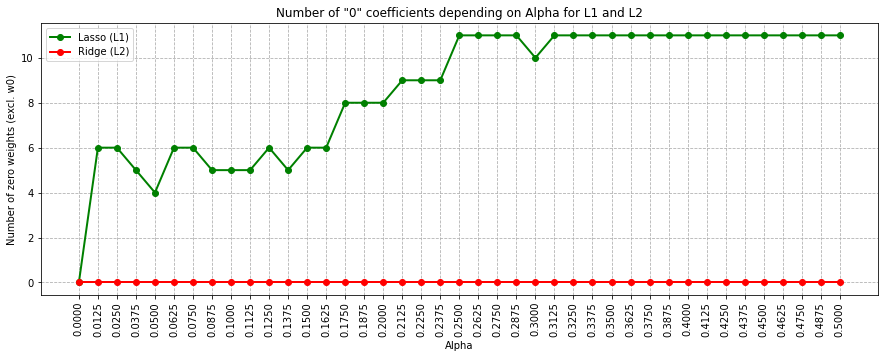

In [30]:
with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.plot(ALPHAS, pd_l1_weights['Zeroed weights w/o w0'], color='green', linestyle="-", marker="o", label='Lasso (L1)')
    plt.plot(ALPHAS, pd_l2_weights['Zeroed weights w/o w0'], color='red', linestyle="-", marker="o", label='Ridge (L2)')
    plt.xlabel('Alpha')
    plt.ylabel('Number of zero weights (excl. w0)')
    plt.xticks(ALPHAS, rotation='vertical')
    plt.legend()     
    plt.title('Number of "0" coefficients (excl. w0) depending on Alpha for L1 and L2') 
    plt.show()

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

<hr>
Scaling is needed when, for example, features have various ranges of values (one feature is measured in millions, another one is measured in thousands and so on - one feature is the salary of a person while another feature is the number of their relatives).<br>
Linear regression is an algorithm that depends on the gradient descent to find the local (and, hopefully, the global) minimum and, as the result, minimize the difference between real and predicted values.<br>
If features are of different scales, gradient descent may converge much slower as each feature needs its own size of the 'step' of gradient descent, so scaling is recommended to improve the performance.<br>
Also, according to the documentation page of StandardScaler, "L1 and L2 regularizers of linear models assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."<br>
Considering that StandardScaler helps to convert values so they become close to Gaussian-distributed, this is another point proving that scaling (and StandardScaler) is an important step that should be taken before fitting a model. 